# 1) 데이터 준비와 확인

In [1]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from collections import Counter
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant
import pprint
import gensim
import gensim.models

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
print(X_train[20])

[405, 1958, 1491, 16, 78, 4, 93, 1640, 1154, 7973, 5, 418, 607]


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# # 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# # 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
import tensorflow as tf
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [9]:
print(index_to_word[5]) 

영화


In [10]:
print(word_to_index['<PAD>'])

0


# 4) 모델 구성 및 validation set 구성 ( 3가지)

In [11]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 86182건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]
print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)


(10000, 41)
(10000,)
(136182, 41)
(136182,)


### A.1-D Convolution Neural Network(1-D CNN) 모델 만들기

In [12]:
# 1-D Convolution Neural Network(1-D CNN) 모델

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

conv1D_model = keras.Sequential()
conv1D_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv1D_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
conv1D_model.add(keras.layers.MaxPooling1D(5))
conv1D_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
conv1D_model.add(keras.layers.GlobalMaxPooling1D())
conv1D_model.add(keras.layers.Dense(8, activation='relu'))
conv1D_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

conv1D_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### B. RNN 모델 만들기

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
rnn_model.add(keras.layers.Dense(8, activation='relu'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### C. GlobalMaxPooling 모델 만들기

In [14]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
gmp_model = keras.Sequential()
gmp_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(keras.layers.GlobalMaxPooling1D())
gmp_model.add(keras.layers.Dense(8, activation='relu'))
gmp_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


# 5) 모델 훈련 개시

### A.1-D Convolution Neural Network(1-D CNN) 모델 훈련, 평가

In [15]:
conv1D_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

conv1D_model_history = conv1D_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 4s 5ms/step - loss: 0.4791 - accuracy: 0.7691 - val_loss: 0.3513 - val_accuracy: 0.8447
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3282 - accuracy: 0.8609 - val_loss: 0.3359 - val_accuracy: 0.8508
Epoch 3/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2974 - accuracy: 0.8757 - val_loss: 0.3291 - val_accuracy: 0.8555
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2713 - accuracy: 0.8890 - val_loss: 0.3323 - val_accuracy: 0.8554
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2432 - accuracy: 0.9031 - val_loss: 0.3441 - val_accuracy: 0.8514
Epoch 6/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2128 - accuracy: 0.9186 - val_loss: 0.3597 - val_accuracy: 0.8496
Epoch 7/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1813 - accuracy: 0.9328 - val_loss: 0.3889 - val_accuracy: 0.8479
Epoch 

In [16]:
conv1D_results = conv1D_model.evaluate(X_test,  y_test, verbose=2)

print(conv1D_results)

1537/1537 - 2s - loss: 0.5263 - accuracy: 0.8361
[0.5263402462005615, 0.8360965847969055]


### B. RNN 모델 훈련, 평가

In [17]:
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

rnn_model_history = rnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 3s 7ms/step - loss: 0.4773 - accuracy: 0.7948 - val_loss: 0.3643 - val_accuracy: 0.8429
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3398 - accuracy: 0.8579 - val_loss: 0.3445 - val_accuracy: 0.8497
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3197 - accuracy: 0.8668 - val_loss: 0.3417 - val_accuracy: 0.8529
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3084 - accuracy: 0.8724 - val_loss: 0.3439 - val_accuracy: 0.8518
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2995 - accuracy: 0.8761 - val_loss: 0.3417 - val_accuracy: 0.8541
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2919 - accuracy: 0.8792 - val_loss: 0.3438 - val_accuracy: 0.8538
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2814 - accuracy: 0.8845 - val_loss: 0.3420 - val_accuracy: 0.8553
Epoch 

In [18]:
rnn_results = rnn_model.evaluate(X_test,  y_test, verbose=2)

print(rnn_results)

1537/1537 - 3s - loss: 0.3682 - accuracy: 0.8467
[0.36821261048316956, 0.846735954284668]


### C. GlobalMaxPooling 1D 모델  훈련, 평가

In [19]:
gmp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gmp_model_history = gmp_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 1s 4ms/step - loss: 0.5973 - accuracy: 0.7043 - val_loss: 0.4449 - val_accuracy: 0.8220
Epoch 2/10
266/266 [==============================] - 1s 3ms/step - loss: 0.3822 - accuracy: 0.8393 - val_loss: 0.3572 - val_accuracy: 0.8431
Epoch 3/10
266/266 [==============================] - 1s 3ms/step - loss: 0.3267 - accuracy: 0.8625 - val_loss: 0.3456 - val_accuracy: 0.8461
Epoch 4/10
266/266 [==============================] - 1s 3ms/step - loss: 0.3001 - accuracy: 0.8750 - val_loss: 0.3453 - val_accuracy: 0.8457
Epoch 5/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2809 - accuracy: 0.8845 - val_loss: 0.3499 - val_accuracy: 0.8493
Epoch 6/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2654 - accuracy: 0.8924 - val_loss: 0.3565 - val_accuracy: 0.8481
Epoch 7/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2521 - accuracy: 0.8989 - val_loss: 0.3653 - val_accuracy: 0.8476
Epoch 

In [20]:
gmp_results = gmp_model.evaluate(X_test,  y_test, verbose=2)

print(gmp_results)

1537/1537 - 2s - loss: 0.4057 - accuracy: 0.8393
[0.4056873619556427, 0.8392701148986816]


# 6) Loss, Accuracy 그래프 시각화

### A.1-D CNN 그래프

In [21]:
conv1D_model_history_dict = conv1D_model_history.history
print(conv1D_model_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


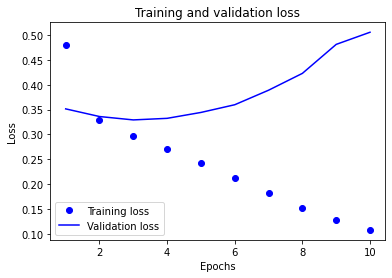

In [22]:
import matplotlib.pyplot as plt

acc = conv1D_model_history_dict['accuracy']
val_acc = conv1D_model_history_dict['val_accuracy']
loss = conv1D_model_history_dict['loss']
val_loss = conv1D_model_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

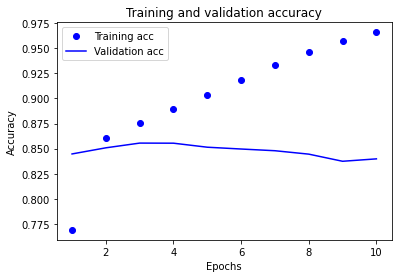

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### B. RNN 모델 그래프

In [24]:
rnn_model_history_dict = rnn_model_history.history
print(rnn_model_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


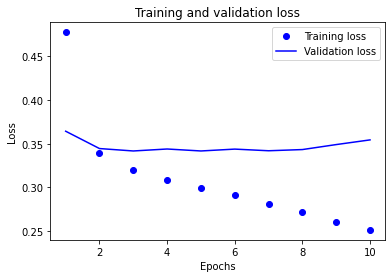

In [25]:
acc = rnn_model_history_dict['accuracy']
val_acc = rnn_model_history_dict['val_accuracy']
loss = rnn_model_history_dict['loss']
val_loss = rnn_model_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

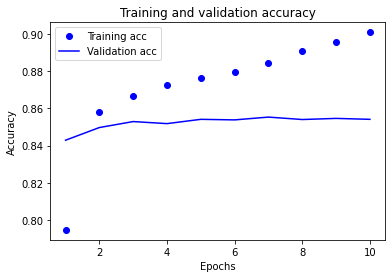

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### C. GlobalMaxPooling 모델 그래프

In [27]:
gmp_model_history_dict = gmp_model_history.history
print(gmp_model_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


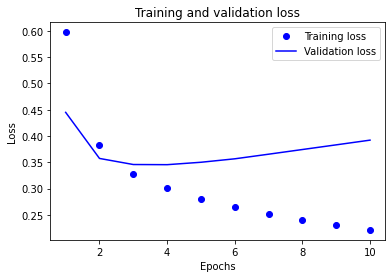

In [28]:
acc = gmp_model_history_dict['accuracy']
val_acc = gmp_model_history_dict['val_accuracy']
loss = gmp_model_history_dict['loss']
val_loss = gmp_model_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

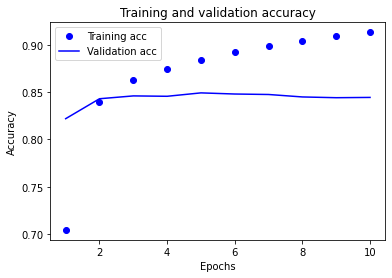

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

### A.1-D CNN 레이어 분석

In [30]:
embedding_layer = conv1D_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [31]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/conv1d_w2v.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = conv1D_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([-0.03491181, -0.1881418 , -0.09400318, -0.09487299, -0.06101597,
       -0.17581536,  0.13543329, -0.11492378,  0.02354406,  0.06945057,
       -0.16762908, -0.09250819, -0.10067564, -0.00585418,  0.03288028,
        0.00594523], dtype=float32)

In [34]:
word_vectors.similar_by_word("행복")

[('막힌', 0.8920122981071472),
 ('적절히', 0.8739099502563477),
 ('치열', 0.8702822327613831),
 ('훈', 0.8628295063972473),
 ('메가', 0.8536322116851807),
 ('게이트', 0.8522397875785828),
 ('리암니슨', 0.8466956615447998),
 ('마모루', 0.8453699946403503),
 ('뿌듯', 0.8422414660453796),
 ('통제', 0.8377120494842529)]

In [35]:
word_vectors.similar_by_word("폭력")

[('손오공', 0.7111847400665283),
 ('고쳐', 0.6961480379104614),
 ('시킴', 0.6889491677284241),
 ('윤발', 0.6719574332237244),
 ('여름', 0.6665558815002441),
 ('흐른다', 0.6640952825546265),
 ('홍어', 0.6509198546409607),
 ('효과음', 0.6468289494514465),
 ('로웠', 0.6459628939628601),
 ('미학', 0.6446555852890015)]

### B. RNN 모델 레이어 분석

In [36]:
embedding_layer = rnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [37]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/rnn_w2v.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = rnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([ 0.08312649,  0.14416818, -0.0763703 ,  0.15255854,  0.13140291,
        0.13522796,  0.07655336,  0.1080505 , -0.16337907, -0.12621439,
        0.05925921,  0.07543402,  0.10413733, -0.17481947,  0.09029102,
       -0.06926484], dtype=float32)

In [40]:
word_vectors.similar_by_word("행복")

[('이스트', 0.9858400821685791),
 ('아플', 0.982796847820282),
 ('어렴풋이', 0.9803470373153687),
 ('테일러', 0.977326512336731),
 ('돌이켜', 0.9768015146255493),
 ('고든', 0.9754589796066284),
 ('I', 0.9749690890312195),
 ('우산', 0.9732271432876587),
 ('소울', 0.9727765321731567),
 ('조상', 0.9726943373680115)]

### C. GlobalMaxPooling  모델 레이어 분석

In [41]:
embedding_layer = gmp_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [42]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/gmp_w2v.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = gmp_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [43]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([ 0.06613845, -0.16869506, -0.04412594, -0.22181106, -0.09663345,
        0.18900481, -0.1601485 ,  0.06405038, -0.14147592,  0.14793284,
       -0.1042989 ,  0.04382021,  0.06148933, -0.12852024,  0.09794167,
       -0.01788133], dtype=float32)

In [44]:
word_vectors.similar_by_word("행복")

[('태어난', 0.7870368957519531),
 ('난리', 0.7586134672164917),
 ('속이', 0.7136566638946533),
 ('하모니', 0.704201340675354),
 ('산드라', 0.7016621828079224),
 ('차지', 0.7012296319007874),
 ('가량', 0.7009082436561584),
 ('1980', 0.6933595538139343),
 ('선', 0.6905918121337891),
 ('싸', 0.6878564357757568)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 

In [45]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [47]:
vocab_size = 10000 #어휘 사전의 크기입니다.
word_vector_dim = 100 # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

#embedding_matrix 에 Word2Vec 워드 벡터를 단어 하나씩 마다 차례차례 카피한다.
for i in range (4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [48]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [49]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 3s 7ms/step - loss: 0.4511 - accuracy: 0.8009 - val_loss: 0.3471 - val_accuracy: 0.8520
Epoch 2/5
266/266 [==============================] - 1s 6ms/step - loss: 0.3282 - accuracy: 0.8626 - val_loss: 0.3354 - val_accuracy: 0.8547
Epoch 3/5
266/266 [==============================] - 1s 6ms/step - loss: 0.3031 - accuracy: 0.8731 - val_loss: 0.3296 - val_accuracy: 0.8568
Epoch 4/5
266/266 [==============================] - 1s 6ms/step - loss: 0.2816 - accuracy: 0.8842 - val_loss: 0.3274 - val_accuracy: 0.8594
Epoch 5/5
266/266 [==============================] - 1s 6ms/step - loss: 0.2585 - accuracy: 0.8948 - val_loss: 0.3303 - val_accuracy: 0.8577


In [51]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3362 - accuracy: 0.8547
[0.33623549342155457, 0.8547307848930359]


### 정확도가 85% 이상이 나옵니다.

In [52]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [53]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/model_w2v.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [54]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.02780747, -0.05280209, -0.03827197,  0.08441019,  0.08276003,
        0.03961272, -0.13159417,  0.09705649, -0.13152882,  0.07758895,
        0.05889256,  0.08723282, -0.05670968, -0.00181983, -0.12003652,
       -0.09857128,  0.035902  , -0.14576957,  0.14492777, -0.11427345,
       -0.06665047,  0.109759  ,  0.1397442 ,  0.13292699, -0.04644313,
        0.10107718,  0.06138723,  0.10983945,  0.09030737, -0.07639737,
        0.07653346, -0.10819803,  0.12493584, -0.09996822,  0.09957585,
       -0.04218496,  0.08849802,  0.11871649,  0.11771578, -0.07753494,
       -0.07074442, -0.11194383,  0.10028712,  0.08706985, -0.05145855,
       -0.15991634, -0.06596639,  0.07834537, -0.07501407,  0.07077401,
       -0.05001374,  0.03052012,  0.13600688, -0.05723247, -0.0947125 ,
        0.13379021, -0.05706818, -0.10072553, -0.0236892 , -0.02284497,
        0.11251128,  0.13408932,  0.09248497, -0.011947  ,  0.09236137,
        0.10300983, -0.01328378, -0.11207844, -0.04837649, -0.10

In [55]:
word_vectors.similar_by_word("사랑")

[('소름', 0.8944135904312134),
 ('부드러운', 0.8941594362258911),
 ('명작', 0.8926259279251099),
 ('아싸', 0.891931414604187),
 ('눈물', 0.8902918100357056),
 ('미소', 0.8898215293884277),
 ('강렬', 0.8888252377510071),
 ('표한다', 0.8857229948043823),
 ('힐링', 0.8844515085220337),
 ('소장', 0.8824882507324219)]

In [56]:
word_vectors.similar_by_word("행복")

[('극대', 0.8965044021606445),
 ('개꿀', 0.8955429196357727),
 ('great', 0.8954768776893616),
 ('흥미진진', 0.8950839042663574),
 ('명작', 0.8947106599807739),
 ('즐겼', 0.892781674861908),
 ('자격', 0.8909209370613098),
 ('명화', 0.8905138373374939),
 ('감탄', 0.889162003993988),
 ('정점', 0.8872002959251404)]

# 회고

마지막에 한국어 Word2Vec를 이용하여 85% 정확도를 달성하기 위해 (epoch = 10)에서 (epoch = 5)로 바꿔어 주었더니 85% 이상이 되었습니다. 비슷한 낱말 출력을 word_vectors.similar_by_word("")을 통해 해보았을 때도 역시 (epoch = 10)일때 보다 (epoch = 5) 일때가 출력되는 단어들이 훨씬 더 자연스럽게 비슷했고 연관성이 더 있게 느껴졌습니다. 